In [1]:
import argparse
import math
import json
import numpy as np
import os
import torch

import librosa
import librosa.display
import IPython.display
from utils.dsp import load_wav
from utils.world import world_split, world_join, logsp_norm, logsp_unnorm

from dataset_world import AudiobookDataset

from hparams import hparams as hp
from model_vc_world import Generator
from synthesis import build_model
from synthesis import wavegen

In [2]:
speaker = 'p226'
tgt_speaker = 'p226'
filename = f'{speaker}_336'

device = torch.device('cpu')

src_wav_path = f'./data/test/{speaker}/{filename}/0000.wav'
src_emb_path = f'./data/test/{speaker}/emb.npy'
tgt_emb_path = f'./data/test/{tgt_speaker}/emb.npy'
autovc_checkpoint_path = 'checkpoints/checkpoint_step000600.pth'

In [3]:
wav = load_wav(src_wav_path)
wav = wav[hp.sample_rate:(256*20-1)*4+hp.sample_rate]
emb = np.load(src_emb_path)
emb_tgt = np.load(tgt_emb_path)

f0, t, sp_in, ap = world_split(wav)
sp = sp_in.reshape((-1, 64, 513))
sp = logsp_norm(np.log(sp))
embs = np.array([ emb for _ in range(sp.shape[0])])

mels = torch.from_numpy(sp.astype(np.float32)).clone()
embs = torch.from_numpy(embs.astype(np.float32)).clone()

print(mels.shape, embs.shape)

torch.Size([4, 64, 513]) torch.Size([4, 256])


In [4]:
model = Generator(hp.dim_neck, hp.dim_emb, hp.dim_pre, hp.freq).to(device)
checkpoint = torch.load(autovc_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
model.eval()

Generator(
  (style_encoder): StyleEncoder(
    (lstm): LSTM(513, 768, num_layers=2, batch_first=True)
    (linear): LinearNorm(
      (linear_layer): Linear(in_features=768, out_features=256, bias=True)
    )
  )
  (encoder): ContentEncoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(769, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (

In [5]:
with torch.no_grad():
    m = mels.to(device)
    e = embs.to(device)
    mel_outputs, mel_outputs_postnet, codes = model(m, e, e)
    m_rec = mel_outputs_postnet
    codes_rec = model(m_rec, e, None)
    L_recon = ((mel_outputs_postnet - m) ** 2).sum(dim=(1,2)).mean()
    L_recon0 = ((mel_outputs - m) ** 2).sum(dim=(1,2)).mean()
    L_content = torch.abs(codes - codes_rec).sum(dim=1).mean()
    loss = L_recon + L_recon0 + L_content
    print('loss', loss.item())

loss 38.53734588623047


In [6]:
sp_out = np.exp(logsp_unnorm(mel_outputs.to('cpu').detach().numpy().copy()))
sp_out = sp_out.reshape((-1, 513)).astype(np.double)

wav_out = world_join(f0, sp_out, ap)

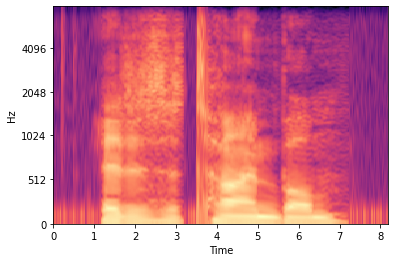

In [7]:
librosa.display.specshow(np.log(sp_in).T, x_axis='time', y_axis='mel', sr=16000)

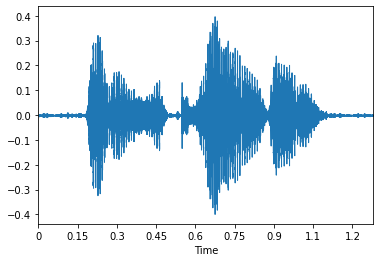

In [8]:
librosa.display.waveplot(wav, sr=16000)

In [9]:
IPython.display.Audio(wav, rate=16000)

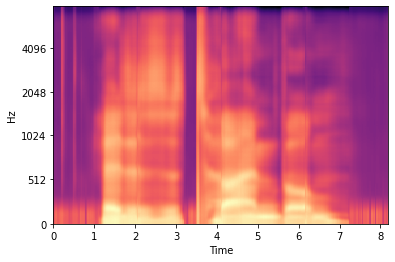

In [10]:
librosa.display.specshow(np.log(sp_out).T, x_axis='time', y_axis='mel', sr=16000)

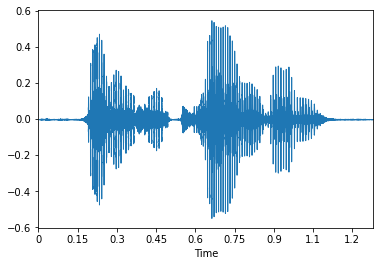

In [11]:
librosa.display.waveplot(wav_out, sr=16000)

In [12]:
IPython.display.Audio(wav_out, rate=16000)